---
title: Moore2009dec simulation for mrfmsim paper
author: Peter Sun  
create-date: July, 2023
date: Apr 9, 2025
versions: mmodel 0.8.1, mrfmsim 0.3.1
---


In this notebook, we pre-treat Moore's data. The phase of the data is
already adjusted so that the data is in the X channel. The data treatment function is from John Marohn's previous notebooks.
In the simulation, we use the CermitTD, the time-dependent
CERMIT simulation to fit the data.

The data is not the same as the paper, it is a different run from Eric Moore.
But the run has more data and better notes, so we decided to use this instead.


In [1]:
# import scipy.signal as signal
import scipy.io
import numpy as np
import matplotlib.pyplot as plt


class freqvsfield(object):
    def __init__(self, filename, title, n):
        self.filename = filename
        self.title = title
        self.n = n

    def load(self):
        """Read the data."""

        mat = scipy.io.loadmat(self.filename)

        data = mat["data"]

        self.f = data
        self.F = data[0, self.n][0, 0][7][0]
        self.X = data[0, self.n][0, 0][5][0]
        self.Y = data[0, self.n][0, 0][6][0]
        # self.p_opt = 0
        # self.message = f.attrs['comment']
        # self.tip_sample = f.attrs['tip-sample_separation']

    def plot(self, inline=True):
        """Plot the X and Y lock-in data versus."""

        plt.figure()
        plt.plot(self.F, self.X, "-o", color="teal", label="X")
        plt.plot(self.F, self.Y, "-", color="grey", label="Y")
        plt.xlabel("B$_0$ [kG]")
        # plt.xlim([34.4,38])
        plt.ylabel("signal [mHz]")
        # plt.ylim([-200,250])
        # plt.vlines(x=1.236*28, ymin=-30, ymax=30, color='g', linestyles = 'dashed')
        plt.title(self.title)
        plt.legend(loc="best")
        plt.grid()
        plt.show()

    def baseline(self, mask):
        self.X = self.X - np.average(self.X[mask])
        self.Y = self.Y - np.average(self.Y[mask])

    def phase(self, p0=0):
        """Autocorrect the phase."""

        phases = np.pi * (np.linspace(0.0, 1.0, 512) + p0)
        rX = np.zeros(phases.size)
        rY = np.zeros(phases.size)

        for idx, p in enumerate(phases):
            Xp = np.cos(p) * self.X + np.sin(p) * self.Y
            Yp = np.sin(p) * self.X - np.cos(p) * self.Y

            rX[idx] = (Xp * Xp).sum()
            rY[idx] = (Yp * Yp).sum()

        self.p_opt = phases[rY.argmin()]

        # print(self.p_opt)
        Xnew = np.cos(self.p_opt) * self.X + np.sin(self.p_opt) * self.Y
        Ynew = np.sin(self.p_opt) * self.X - np.cos(self.p_opt) * self.Y

        self.Xorig = self.X
        self.Yorig = self.Y

        self.X = Xnew
        self.Y = Ynew

    def pick_phase(self, p0=0):
        """Autocorrect the phase."""

        phases = np.pi * (np.linspace(0.0, 1.0, 512) + p0)
        rX = np.zeros(phases.size)
        rY = np.zeros(phases.size)

        for idx, p in enumerate(phases):
            Xp = np.cos(p) * self.X + np.sin(p) * self.Y
            Yp = np.sin(p) * self.X - np.cos(p) * self.Y

            rX[idx] = (Xp * Xp).sum()
            rY[idx] = (Yp * Yp).sum()

        self.p_opt = phases[rY.argmin()]

        # print(self.p_opt)
        Xnew = np.cos(self.p_opt) * self.X + np.sin(self.p_opt) * self.Y
        Ynew = np.sin(self.p_opt) * self.X - np.cos(self.p_opt) * self.Y

        self.Xorig = self.X
        self.Yorig = self.Y

        self.X = Xnew
        self.Y = Ynew

The following data is from (reportedly) notebook 3 page 74

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = {}
filename = "data/moore/Moore 20081201 distance dependence.mat"

# Moore nb 3 pp 74
mat = scipy.io.loadmat(filename)
for i in range(10):
    tip_samp = float(mat["data"][0, i][0, 0][3][0].split(" ")[0])

    a = freqvsfield(filename, "tip sample = " + str(tip_samp), i)
    a.load()
    if tip_samp < 100.0:
        a.baseline(a.F > 8.0)
        a.phase(0.0)

        std = np.std(a.X[a.F > 8.0])
        mean = np.mean(a.X[a.F > 8.0])

        # print(std)

        val, k = 0, 0
        while abs(val - mean) < 2 * std:
            k = k - 1
            val = a.X[k]

        a.bound = a.F[k]

    else:
        a.baseline(a.F > 7.75)
        a.phase(0.0)

        std = np.std(a.X[a.F > 7.75])
        mean = np.mean(a.X[a.F > 7.75])

        val, k = 0, 0
        while abs(val - mean) < 4 * std:
            k = k - 1
            val = a.X[k]

        a.bound = a.F[k]

    a.angle = np.arctan2(a.Y, a.X)

    data[tip_samp] = a
# sort
data = dict(sorted(data.items()))

Plot the data

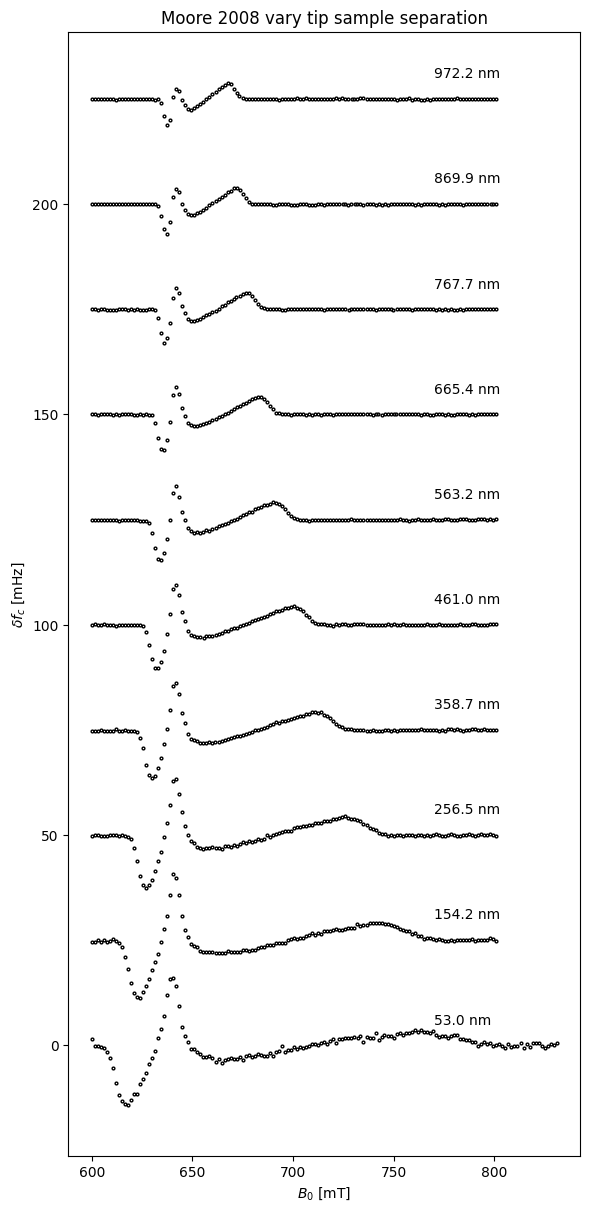

In [3]:
plt.rcParams["figure.figsize"] = 6, 12

for i, n in enumerate(data.keys()):
    plt.plot(
        data[n].F * 100,
        data[n].X * 1000.0 + 25 * i,
        "o",
        mfc="none",
        color="black",
        markersize=2,
    )
    plt.text(770, 25 * i + 5, str(n) + " nm")
plt.xlabel("$B_0$ [mT]")
plt.ylabel("$\delta f_c$ [mHz]")
plt.tight_layout()
plt.title("Moore 2008 vary tip sample separation")
# plt.savefig("moore_vary_tip_sample.pdf")
plt.show()

# Experiment Simulation

The large tip simulation is the "CermitTD" under the "CermitTDGroup"


In [4]:
from mrfmsim.component import SphereMagnet, Sample, Grid, Cantilever
import numpy as np
from mrfmsim.experiment import CermitTDGroup
from mmodel.shortcut import loop_shortcut


CermitTD = CermitTDGroup.experiments["CermitTD"]
print(CermitTD)

CermitTD(B0, B1, cantilever, dt_pulse, f_rf, grid, h, magnet, mw_x_0p, sample,
tip_v)
returns: df_spin
group: CermitTDGroup
graph: CermitTD_graph
handler: MemHandler

Time-dependent CERMIT experiment for a large tip.


In [5]:
magnet = SphereMagnet(
    magnet_radius=1375.9, mu0_Ms=523.1, magnet_origin=[0, 1375.9, 0.0]
)
sample = Sample(spin="e", T1=1.3e-3, T2=0.45e-6, spin_density=0.0241, temperature=11.0)
# eric moore spam geometry, very shallow grid
grid = Grid(
    grid_shape=(501, 11, 1101),
    grid_step=[20.0, 20.0, 20.0],
    grid_origin=[0.0, -100.0, 0.0],
)
cantilever = Cantilever(k_c=7.8e2, f_c=5.512e3)

# we use the same coil constant
c_uT = 1.0 / 1.2  # coil constant uT^2/mW
dBm = -10.0  # dB gain
power = 10.0 ** ((dBm + 20.0) / 10.0)  # mW
B1 = np.sqrt(power * c_uT) / 1000.0  # mT
x_0p = 164.0
tip_v = x_0p * cantilever.f_c * 2 * np.pi

# eric pulses every three cycles
dt_step = 1 / cantilever.f_c * 3
f_rf = 18.1e9  # Hz

Here we simulate the Moore data.
First, we create a looped model with looped h and B0.

In [6]:
CermitTD_looped = loop_shortcut(loop_shortcut(CermitTD, "B0"), "h")

print(CermitTD_looped)

CermitTD(B0_loop, B1, cantilever, dt_pulse, f_rf, grid, h_loop, magnet, mw_x_0p,
sample, tip_v)
returns: df_spin
group: CermitTDGroup
graph: CermitTD_graph
handler: MemHandler

Time-dependent CERMIT experiment for a large tip.


(The following calculation takes about 2 minutes.)

In [7]:
h_list = [[0, sep, 0] for sep in data.keys()]
B0_list = np.arange(600, 805, 2.5)
# B0_list = np.arange(605.0, 805.0, 25)
# B0_list = np.array([627.5, 633.5, 640, 645, 657.5, 707.5, 725])

df_spin_list = CermitTD_looped(
    B0_list, B1, cantilever, dt_step, f_rf, grid, h_list, magnet, x_0p, sample, tip_v
)

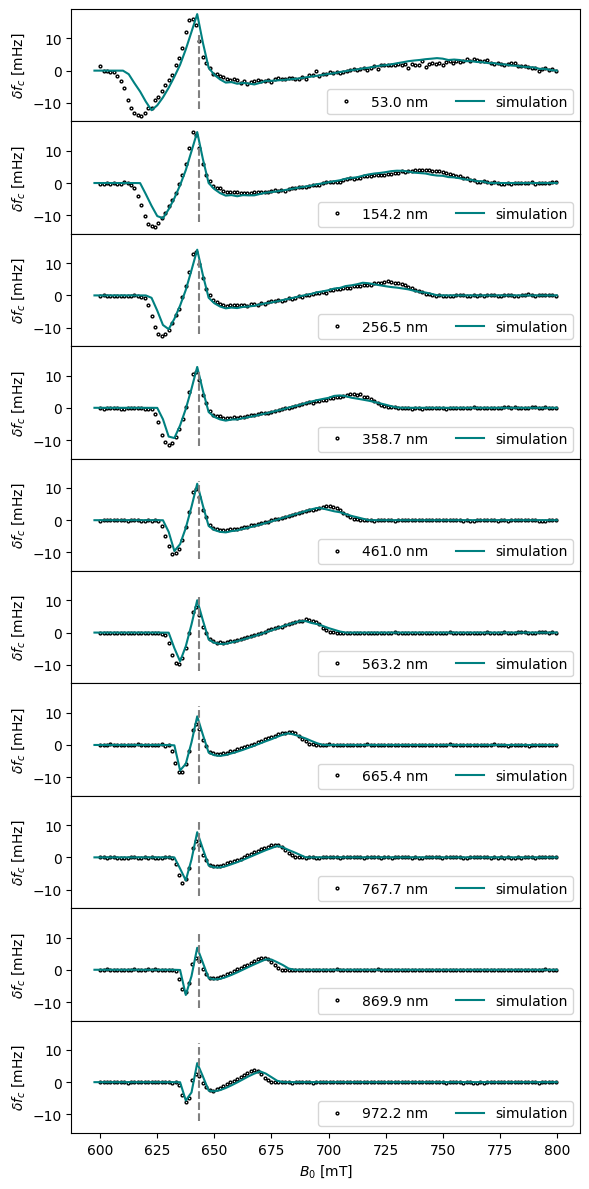

In [8]:
# Without the the tip field, the external field that will give
# the Larmor frequency f_rf is
B_larmor = f_rf / sample.Gamma * 2 * np.pi
B_larmor

fig = plt.figure(figsize=(6, 12))

gs = fig.add_gridspec(len(data), hspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for i, d in enumerate(data.keys()):
    axs[i].plot(
        data[d].F[0:134] * 100,
        data[d].X[0:134] * 1000.0,
        "o",
        mfc="none",
        color="black",
        markersize=2,
        label=f"{d} nm",
    )
    axs[i].plot(
        B0_list - 2.5, np.array(df_spin_list[i]), "-", color="teal", label="simulation"
    )
    axs[i].vlines(
        x=B_larmor - 2.5,
        ymin=-12,
        ymax=12,
        color="grey",
        linestyles="dashed",
        # label="Larmor",
    )

    axs[i].legend(loc="lower right", ncol=2)
    # axs[i].set_ylim([np.min(df_spin_list[i]) - 10, np.max(df_spin_list[i]) + 12])

for ax in axs.flat:
    ax.label_outer()
    ax.set_xlabel("$B_0$ [mT]")
    ax.set_ylabel("$\delta f_c$ [mHz]")

# axs[0].set_title(
#     "Fit comparison Moore 2008,\n $^e, 11 K, 0.0241 nm$^{-3}$ spins, "
#     "\n 1.3 ms $T_1$, 0.45 $\mathrm{\mu}$s $T_2$, 18.1 GHz $f_\mathrm{rf}$, 2.89 $\mathrm{\mu}$T $B_1$"
# )
plt.tight_layout()
plt.savefig("figures/moore_fit_comparison.pdf", bbox_inches="tight")
plt.show()

Note there is a about -2.5 mT shift for all spectra, the adjustment is made based on the "bulk" peak shift (B external when f_rf is the Larmor frequency). One of the sources could be the rf does not output the exact frequency. 

## Observation

In the paper the peaks are specified as Ba - Bd. Here we use the definition but also include the other features as well.
Here we look at some observations:

- The initial dip, the dip (Ba peak) moves closer to the Bb peak.
- Bb peak remains in the same location.
- Bc dip and Bc peak move closer to Bb peak.
- Bd moves closer to Bb.

It is not obvious that Bb remains the same and Bc dip moves. Below we printout the height of the peaks and dips, as well as
Bb and Bc dip locations.


In [9]:
index = np.where(np.array(B0_list) >= 650)[0][0]  # index for the second part
for df_spin in df_spin_list:
    df_spin = np.array(df_spin)
    print(f"Ba dip {df_spin.min():6.2f}", end=" | ")
    print(f"Bb max {df_spin.max():6.2f}", end=" | ")
    print(f"Bc dip {df_spin[index:].min():6.2f}", end=" | ")
    print(f"Bc peak {df_spin[index:].max():6.2f}", end=" | ")
    print(f"Ba dip loc {np.where(df_spin == df_spin.min())[0][0]:2d}", end=" | ")
    print(f"Bb loc {np.where(df_spin == df_spin.max())[0][0]:2d}", end=" | ")
    print(
        f"Bc dip loc {np.where(df_spin == df_spin[index:].min())[0][0]:2d}", end=" | "
    )
    print(f"Bc peak loc {np.where(df_spin == df_spin[index:].max())[0][0]:2d}")

Ba dip -12.28 | Bb max  17.53 | Bc dip  -4.29 | Bc peak   3.88 | Ba dip loc 10 | Bb loc 18 | Bc dip loc 28 | Bc peak loc 60
Ba dip -10.92 | Bb max  15.81 | Bc dip  -4.11 | Bc peak   3.82 | Ba dip loc 12 | Bb loc 18 | Bc dip loc 25 | Bc peak loc 53
Ba dip -10.47 | Bb max  14.18 | Bc dip  -4.01 | Bc peak   3.93 | Ba dip loc 13 | Bb loc 18 | Bc dip loc 23 | Bc peak loc 47
Ba dip  -9.38 | Bb max  12.67 | Bc dip  -3.98 | Bc peak   3.84 | Ba dip loc 14 | Bb loc 18 | Bc dip loc 23 | Bc peak loc 43
Ba dip  -9.57 | Bb max  11.31 | Bc dip  -3.78 | Bc peak   3.79 | Ba dip loc 14 | Bb loc 18 | Bc dip loc 23 | Bc peak loc 39
Ba dip  -8.93 | Bb max  10.03 | Bc dip  -3.53 | Bc peak   3.57 | Ba dip loc 15 | Bb loc 18 | Bc dip loc 22 | Bc peak loc 37
Ba dip  -7.89 | Bb max   8.88 | Bc dip  -3.38 | Bc peak   3.62 | Ba dip loc 15 | Bb loc 18 | Bc dip loc 22 | Bc peak loc 34
Ba dip  -7.14 | Bb max   7.81 | Bc dip  -3.12 | Bc peak   3.56 | Ba dip loc 16 | Bb loc 18 | Bc dip loc 22 | Bc peak loc 32
Ba dip  

# Lineshape

Like the Longenecker notebook, here we look at the lineshape by looking at the signal component at each position at 635 mT, 645.85 mT, 680 mT.
In this case, we modify the graph of the last node and then save the plots.

Define the plotting node:

In [10]:
# mrfmsim-plot should be used once the bug is fixed
from modpv import pv_plot_preset, pv_preset_volume

# from mrfmsim.pvplot import pv_plot_present, pv_preset_volume

from mrfmsim import Node

In [11]:
def plot_force_variance(
    Bzxx,
    B_tot,
    B0,
    rel_dpol_avg,
    mz_eq,
    file_path,
    spin_density,
    grid_voxel,
    k2f_modulated,
    h,
    grid,
):
    """Plotted the force variance and associated properties."""
    df_spin = Bzxx * rel_dpol_avg * mz_eq * spin_density * grid_voxel * k2f_modulated

    Bz = B_tot - B0  # ignore the extend portion
    fnames = ["Bzxx", "dPol", "Bz", "df"]
    vnames = ["dBz/dx^2", "dPol", "Bz", "df"]
    units = [" [mT/nm^2]", "", " [mT]", " [mHz]"]

    fmt = "%.2e"
    # "window_size": (512, 768),
    for i, data in enumerate([Bzxx, rel_dpol_avg, Bz, df_spin]):
        file = f"{file_path}/{fnames[i]}_{round(h[1], 2)}nm_{round(B0, 2)}mT.png"

        n_labels = 5
        clim = None
        if fnames[i] == "Bz":

            clim = [-90, 18]
            fmt = "%.1f"
            n_labels = 7
        elif fnames[i] == "Bzxx":

            clim = [-2.45e-5, 9.8e-5]
            n_labels = 6
        elif fnames[i] == "dPol":
            clim = [data.min(), 0]
            fmt = "%.2f"
            if abs(data).min() < 0.01:
                fmt = "%.2e"

        elif fnames[i] == "df":

            clim = None
            fmt = "%.2e"

        present = pv_preset_volume(
            data,
            grid,
            add_volume=dict(clim=clim),
            add_axes=dict(viewport=(0.7, 0, 1.0, 0.3)),
            add_scalar_bar=dict(
                title=f"{vnames[i]}\n{units[i]}",
                fmt=fmt,
                n_labels=n_labels,
            ),
        )
        pl = pv_plot_preset(present)
        pl.camera.zoom(1.5)
        pl.screenshot(file, transparent_background=True)
        pl.close()

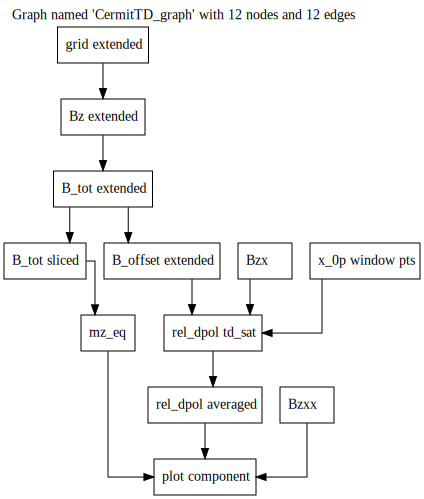

In [12]:
G = CermitTD.graph

H = G.subgraph(["spring constant shift td", "frequency shift"])
new_G = G.replace_subgraph(H, Node("plot component", plot_force_variance))
new_G.visualize()

In [13]:
new_G = G.deepcopy()

new_node = Node("plot component", plot_force_variance)
new_edges = []
for node in H.nodes():
    for parent in new_G.predecessors(node):
        if parent not in H:
            new_edges.append((parent, new_node.name))
    for child in new_G.successors(node):
        if child not in H:
            new_edges.append((new_node.name, child))

In [14]:
new_G.remove_nodes_from(H.nodes)
new_G.add_edges_from(set(new_edges))
new_G.add_node_object(new_node)
CermitTD.edit(graph=new_G, allow_duplicated_components=True)

<mrfmsim.model.Experiment 'CermitTD'>

In [15]:
new_G = G.replace_subgraph(H, Node("plot component", plot_force_variance))
new_G.visualize()

# need to allow duplicated components here
cermittd_plots = CermitTD.edit(graph=new_G, allow_duplicated_components=True)

print(cermittd_plots)

CermitTD(B0, B1, cantilever, dt_pulse, f_rf, file_path, grid, h, magnet,
mw_x_0p, sample, tip_v)
returns: None
group: CermitTDGroup
graph: CermitTD_graph
handler: MemHandler

Time-dependent CERMIT experiment for a large tip.


Here we loop the plotting function to show each component at different positions (note that the final reported value and simulated value have a 2.5 mT shift.) We pick the 358.7 for distinct features.

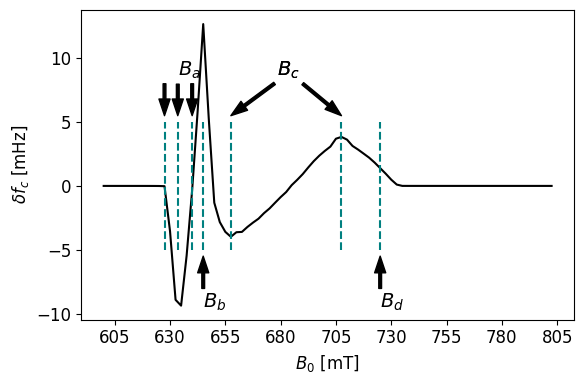

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = ["DejaVu Sans"]

# Set global font size to 12
plt.rcParams.update({"font.size": 12})

# mpl.rcParams['font.serif'] = ['Noto Serif CJK JP']

plt_B0_list = [627.5, 633.5, 640, 645, 657.5, 707.5, 725]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    B0_list,
    np.array(df_spin_list[list(data.keys()).index(358.7)]),
    "-",
    color="black",
)
plt.xlabel("$B_0$ [mT]")
plt.xticks(np.arange(605, 810, 25))
plt.ylabel("$\delta f_c$ [mHz]")

for i, B0 in enumerate(plt_B0_list):
    # Add arrows that point from the line to text

    plt.vlines(x=B0, ymin=-5, ymax=5, color="teal", linestyles="dashed")
    # plt.text(B0, text_pos[i], text[i],  va="top", ha="center", fontsize=12)

# manually add the arrow and annotation

arrowprops = {"facecolor": "black", "width": 2, "headwidth": 8}
fontsize = 14

plt.annotate(
    "",
    xy=(plt_B0_list[0], 5.5),  # Arrow tip at the line
    xytext=(plt_B0_list[0], 8),  # Text position
    # arrowprops=arrow_props)
    fontsize=fontsize,
    arrowprops=arrowprops,
)


plt.annotate(
    "$B_a$",
    xy=(plt_B0_list[1], 5.5),
    xytext=(plt_B0_list[1], 8.6),
    fontsize=fontsize,
    arrowprops=arrowprops,
)


plt.annotate(
    "",
    xy=(plt_B0_list[2], 5.5),
    xytext=(plt_B0_list[2], 8),
    fontsize=fontsize,
    arrowprops=arrowprops,
)


plt.annotate(
    "$B_d$",
    xy=(plt_B0_list[-1], -5.5),
    xytext=(plt_B0_list[-1], -9.5),
    fontsize=fontsize,
    arrowprops=arrowprops,
)

Bc_loc = (plt_B0_list[4] + plt_B0_list[5]) / 2
plt.annotate(
    "$B_c$",
    xy=(plt_B0_list[5], 5.5),
    xytext=(Bc_loc - 4, 8.6),
    fontsize=fontsize,
    arrowprops=arrowprops,
)
plt.annotate(
    "$B_c$",
    xy=(plt_B0_list[4], 5.5),
    xytext=(Bc_loc - 4, 8.6),
    fontsize=fontsize,
    arrowprops=arrowprops,
)

plt.annotate(
    "$B_b$",
    xy=(plt_B0_list[3], -5.5),
    xytext=(plt_B0_list[3], -9.5),
    fontsize=fontsize,
    arrowprops=arrowprops,
)

plt.tight_layout()
plt.savefig("figures/moore_lineshape_358.7.pdf")
plt.show()

In [17]:
cermittd_plot_looped = loop_shortcut(cermittd_plots, "B0")
print(cermittd_plot_looped)

CermitTD(B0_loop, B1, cantilever, dt_pulse, f_rf, file_path, grid, h, magnet,
mw_x_0p, sample, tip_v)
returns: None
group: CermitTDGroup
graph: CermitTD_graph
handler: MemHandler

Time-dependent CERMIT experiment for a large tip.


In [18]:
cermittd_plot_looped(
    plt_B0_list,
    B1,
    cantilever,
    dt_step,
    f_rf,
    "figures/lineshape/moore",
    grid,
    [0, 358.7, 0],
    magnet,
    x_0p,
    sample,
    tip_v,
)